In [1]:
# 1. 导入模块
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.transforms import  Lambda

In [2]:
# 2. 检查设备
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# 3. 定义超参数
input_size = 784  # 28x28 像素 (not directly used in CNN)
num_classes = 2  # 标签类别数
learning_rate = 0.001  # 学习率
batch_size = 4   # 分批训练的每一批数量
num_epochs = 10  # 对整个数据集的迭代次数(一遍一遍的学习的重复遍数)


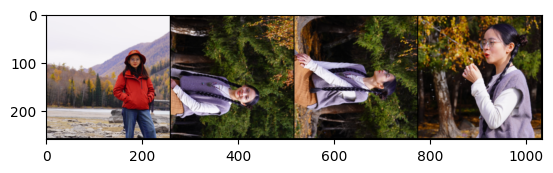

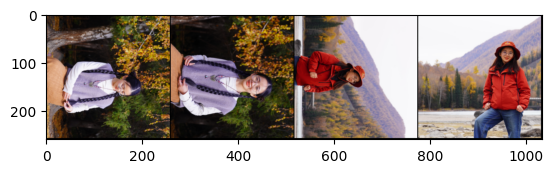

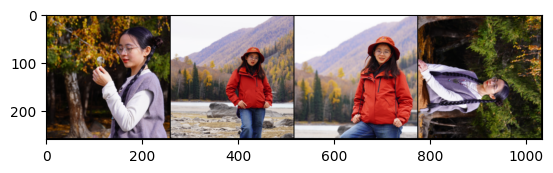

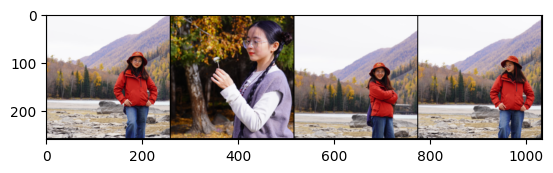

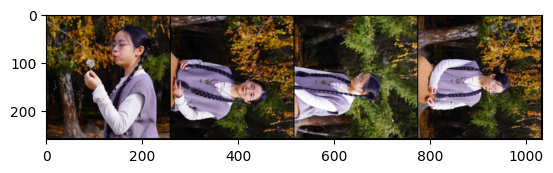

In [4]:
from torch.utils.data import Dataset
import pandas as pd
import os
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import torchvision.transforms as transforms

# 将自己的文件定义为数据集
transforms = transforms.Compose([
    transforms.Resize(256),    # 将图片短边缩放至256，长宽比保持不变：
    transforms.CenterCrop(256),   #将图片从中心切剪成3*224*224大小的图片
])
target_transform = Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(y) - 1, value=1))
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
            image = image.float() / 255.0
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
annotations_file=r"D:\Program Projects\Python Projects\ML-DeepLearning\卷积神经网络\data\labels.csv"
img_dir=r"D:\Program Projects\Python Projects\ML-DeepLearning\卷积神经网络\data\custom"
data = CustomImageDataset(annotations_file=annotations_file,img_dir=img_dir,transform=transforms)
train_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

for i, data in enumerate(train_loader):
    images, labels = data
 
    # 打印数据集中的图片
    img = torchvision.utils.make_grid(images).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()



In [5]:
# 定义卷积神经网络
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super(CNN, self).__init__()
        
        # 卷积，输入1/3通道，输出8通道
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)

        # 批量归一化，减少梯度消失或梯度爆炸问题。通过稳定输入分布，模型可以更快收敛，具有一定的正则化作用，减少过拟合风险
        self.bn1 = nn.BatchNorm2d(8)  # 加入 BatchNorm

        # 池化降采样
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 卷积，输入8通道，输出16通道
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)

        # 批量归一化，减少梯度消失或梯度爆炸问题。通过稳定输入分布，模型可以更快收敛，具有一定的正则化作用，减少过拟合风险
        self.bn2 = nn.BatchNorm2d(16)

        # 全局池化，动态调整尺寸
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # 全连接层
        self.fc1 = nn.Linear(16*256*256, num_classes)

    def forward(self, x):


        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        # x = self.pool(x)


        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        # x = self.pool(x)
      
        # x = self.global_pool(x)  # 全局池化
        # print(x.shape)
        x = x.view(x.size(0), -1)  # 展平
        # print(x.shape)
        x = self.fc1(x)  # 全连接层
        return x

In [6]:
# 6. 初始化模型
model = CNN(in_channels=3, num_classes=num_classes).to(device)

In [7]:
# 7. 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## 训练与验证：方式1

In [8]:
# 8. 定义训练和测试函数
def train_loop(dataloader, model, loss_fn, optimizer):

    # 将模型设置为训练模式--这对批量归一化和丢弃层很重要
    model.train()

    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(tqdm(dataloader)):

        # 计算预测值和损失
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # 反向传播
        loss.backward() # 计算梯度
        optimizer.step() # 更新梯度
        optimizer.zero_grad() # 梯度清空

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * batch_size + len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    loss, current = loss.item(), batch * batch_size + len(X)
    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):

    # 将模型设置为评估模式--这对批量归一化和丢弃层很重要
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # 使用 torch.no_grad() 评估模型可确保在测试模式下不计算梯度。
    # 还可减少不必要的梯度计算和内存使用，适用于 requires_grad=True 的张量系数
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:

# 9. 开始训练和预测
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


loss: 0.629088  [   20/   20]


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Test Error: 
 Accuracy: 85.0%, Avg loss: 0.219162 

Epoch 2
-------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


loss: 0.000000  [   20/   20]


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000008 

Epoch 3
-------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


loss: 0.000000  [   20/   20]


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Epoch 4
-------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


loss: 0.000000  [   20/   20]


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Epoch 5
-------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


loss: 0.000000  [   20/   20]


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Epoch 6
-------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


loss: 0.000000  [   20/   20]


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Epoch 7
-------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


loss: 0.000000  [   20/   20]


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Epoch 8
-------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


loss: 0.000000  [   20/   20]


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Epoch 9
-------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


loss: 0.000000  [   20/   20]


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Epoch 10
-------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


loss: 0.000000  [   20/   20]


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Done!


## 训练与验证：方式2

In [10]:
# 8. 开始训练
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        X = X.to(device)
        y = y.to(device)

        preds = model(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

Epoch [1/10]


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [2/10]


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [3/10]


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch [4/10]


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [5/10]


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [6/10]


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch [7/10]


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch [8/10]


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch [9/10]


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch [10/10]


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


In [11]:
# 开始测试
def check_accuracy(dataset_loader, model):

    # if dataset_loader.dataset.train:
    #     print("检查训练数据的准确性")
    # else:
    #     print("检查测试数据的准确性")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():  # 禁用梯度计算
        for x, y in dataset_loader:
            x = x.to(device)
            y = y.to(device)

            # 前向传递: 计算模型输出
            scores = model(x)
            _, predictions = scores.max(1)  # 获取最大对数概率的索引
            num_correct += (predictions == y).sum()  # 统计正确预测
            num_samples += predictions.size(0)  # 统计全部样本

        # 计算精确度
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")
    
    model.train()  # Set the model back to training mode

# Final accuracy check on training and test sets
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Got 20/20 with accuracy 100.00%
Got 20/20 with accuracy 100.00%
